In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import cv2

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
training = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 500 files for training.


In [5]:
validation = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 124 files for validation.


In [6]:
classes = training.class_names
print(classes)

['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']


In [7]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normlayer = layers.Rescaling(1./255)

In [11]:
normdata = training.map(lambda x, y: (normlayer(x), y))
image_batch, labels_batch = next(iter(normdata))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
numclass = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numclass)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
epochs=20
history = model.fit(
  training,
  validation_data=validation,
  epochs=epochs)

Epoch 1/20
16/16 [==============================] - 10s 492ms/step - loss: 2.3344 - accuracy: 0.1920 - val_loss: 2.0893 - val_accuracy: 0.3145
Epoch 2/20
16/16 [==============================] - 7s 437ms/step - loss: 1.6665 - accuracy: 0.4940 - val_loss: 1.6196 - val_accuracy: 0.5726
Epoch 3/20
16/16 [==============================] - 7s 440ms/step - loss: 0.9168 - accuracy: 0.7160 - val_loss: 0.9776 - val_accuracy: 0.7419
Epoch 4/20
16/16 [==============================] - 7s 442ms/step - loss: 0.3905 - accuracy: 0.8940 - val_loss: 0.8213 - val_accuracy: 0.8065
Epoch 5/20
16/16 [==============================] - 7s 440ms/step - loss: 0.1175 - accuracy: 0.9720 - val_loss: 0.8576 - val_accuracy: 0.8468
Epoch 6/20
16/16 [==============================] - 7s 457ms/step - loss: 0.0453 - accuracy: 0.9900 - val_loss: 0.7485 - val_accuracy: 0.8871
Epoch 7/20
16/16 [==============================] - 7s 442ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 1.0149 - val_accuracy: 0.8790
Epoch

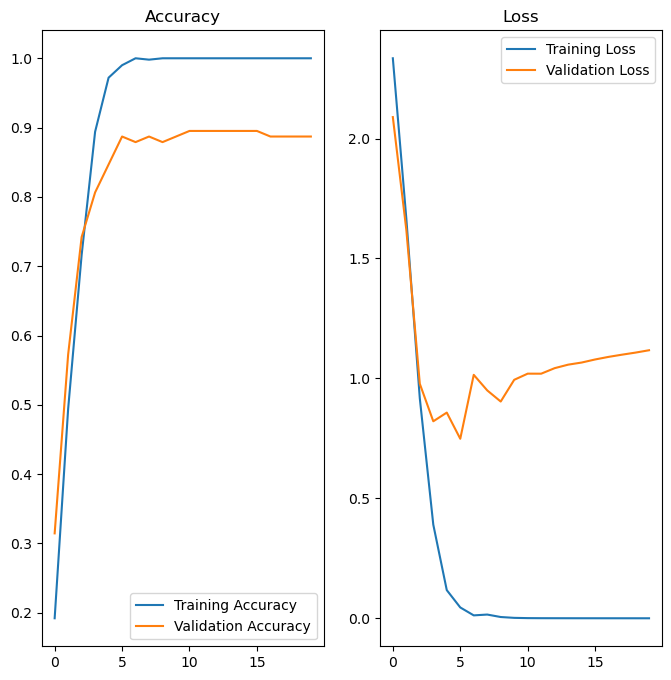

In [16]:
tacc = history.history['accuracy']
vacc = history.history['val_accuracy']

tloss = history.history['loss']
vloss = history.history['val_loss']

eprange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(eprange, tacc, label='Training Accuracy')
plt.plot(eprange, vacc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(eprange, tloss, label='Training Loss')
plt.plot(eprange, vloss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [17]:
def prediction(datpath, model):
    img_height, img_width = 180, 180
    im = tf.keras.utils.load_img(datpath, target_size=(img_height, img_width))
    imarray = tf.keras.utils.img_to_array(im)
    imarray = tf.expand_dims(imarray, 0) 
    predict = model.predict(imarray)
    classindex = np.argmax(predict[0])
    return classindex

In [18]:
model.save('my_model.keras')
loaded_model = tf.keras.models.load_model('model.h5')

In [19]:
dat = 'C:/Users/pragn/Downloads/dataset_T2MRI/Astrocitoma/006be184fb63e8806d40bc970ff4d6_big_gallery.jpg'
mri = cv2.imread(dat)
classindex = prediction(dat, model)

1/1 [==============================] - 0s 295ms/step


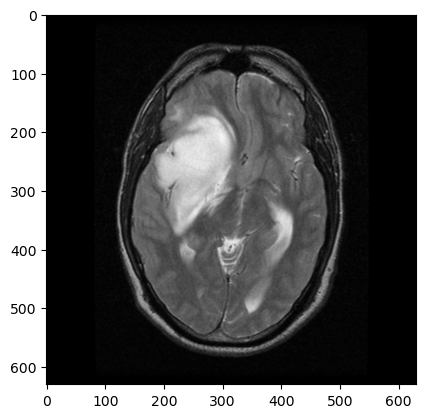

In [20]:
plt.imshow(mri)

In [21]:
seg = mri.reshape(-1, 3)
seg = np.float32(seg)

In [22]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_,labels,centers = cv2.kmeans(seg, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((mri.shape[:-1]))
redu = np.uint8(centers)[labels]

In [23]:
segmentation = [np.hstack([mri, redu])]
for i, c in enumerate(centers):
    mask = cv2.inRange(labels, i, i)
    mask = np.dstack([mask]*3) 
    tumor = cv2.bitwise_and(mri, mask)

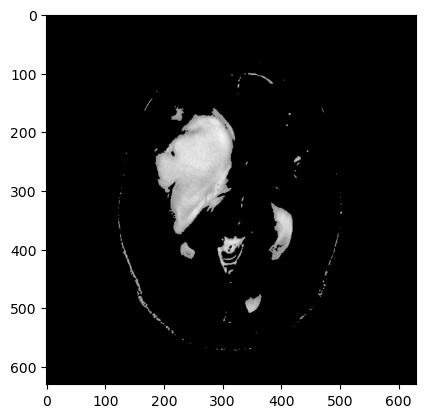

In [24]:
plt.imshow(tumor)

In [25]:
kernel = np.ones((3, 3), np.uint8)

Noise Reduction


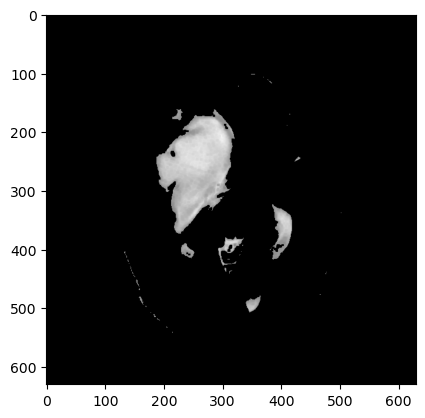

In [26]:
eroded = cv2.erode(tumor, kernel, iterations= 1)
plt.imshow(eroded)
print("Noise Reduction")

In [27]:
tum = eroded
grey = cv2.cvtColor(tum, cv2.COLOR_BGR2GRAY)
thresh = cv2.convertScaleAbs(grey)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
anomaly = max(contours, key=cv2.contourArea)

In [28]:
cv2.drawContours(tum, [anomaly], -1, (191, 54, 12), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

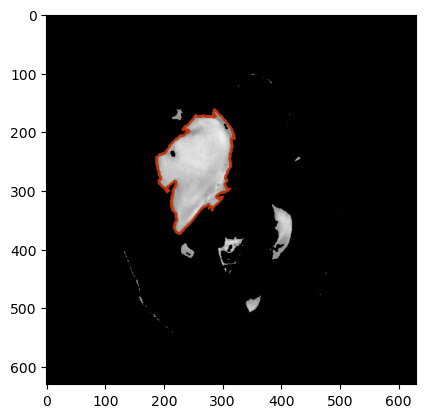

In [29]:
plt.imshow(tum)

In [38]:
import cv2 as cv
x,y,w,h = cv.boundingRect(anomaly)

def zoom_at(tum, zoom_factor=1.5):
    return cv.resize(tum, None, fx=zoom_factor, fy=zoom_factor)
crop = tum[y:y+h,x:x+w]
zoomed = zoom_at(crop, 2)

SYSTEM SUMMARY:
-------------------------------------------
Intracranial Tumor Type: Astrocitoma


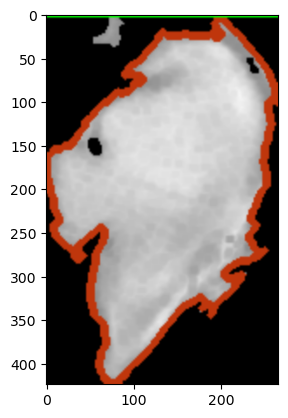

In [39]:
types = ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
print("SYSTEM SUMMARY:")
print("-------------------------------------------")
print("Intracranial Tumor Type: "+types[classindex])
plt.imshow(zoomed)

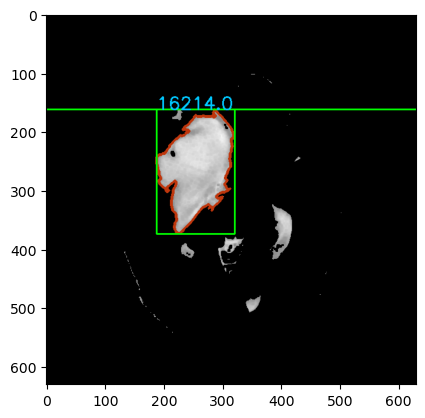

In [57]:
area = cv2.contourArea(anomaly)
x, y, w, h = cv2.boundingRect(anomaly) 
cv2.rectangle(zoomed, (x, y), (x+w, y+h), (0, 255, 0), 2) 
cv2.putText(zoomed, str(area), (x, y), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 255), 2) 
plt.imshow(tum)